In [ ]:
!pip install transformers datasets pandas torch scikit-learn
!pip uninstall torch -y
!pip install torch torchvision torchaudio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


In [ ]:
import torch

# Select device (use CPU if MPS or CUDA are unavailable)
device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load Custom Dataset
custom_path = "/content/drive/MyDrive/base_data_full.csv"
custom_data = pd.read_csv(custom_path)

# Ensure correct data types
custom_data = custom_data.dropna()  # Remove missing values
custom_data['sentence'] = custom_data['sentence'].astype(str)  # Ensure sentences are strings
custom_data['sentiment'] = custom_data['sentiment'].str.lower()  # Normalize sentiment column to lowercase

# Map sentiment to numerical labels
sentiment_mapping = {"negative": 0, "positive": 1, "neutral": 2}
custom_data['label'] = custom_data['sentiment'].map(sentiment_mapping)

# Convert to Hugging Face Dataset
custom_dataset = Dataset.from_pandas(custom_data[['sentence', 'label']])

# Load Pretrained BERTweet
model_name = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Tokenization Function
def tokenize_function(examples):
    return tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=128)

custom_dataset = custom_dataset.map(tokenize_function, batched=True)
custom_dataset = custom_dataset.rename_column("label", "labels")
custom_dataset.set_format(type="torch", columns=['input_ids', 'attention_mask', 'labels'])

# Split Dataset for Training and Validation
custom_dataset = custom_dataset.train_test_split(test_size=0.2)
train_dataset = custom_dataset['train']
eval_dataset = custom_dataset['test']

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./finetuned_results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./finetuned_logs",
    logging_steps=10,
    save_strategy="epoch"
)

# Evaluation Metrics
def compute_metrics(pred):
    predictions = pred.predictions.argmax(-1)
    labels = pred.label_ids
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

# Fine-Tune the Model
trainer.train()

# Save the Fine-Tuned Model
model.save_pretrained("/content/drive/MyDrive/finetuned_bertweet_model")
tokenizer.save_pretrained("/content/drive/MyDrive/finetuned_bertweet_tokenizer")

# Evaluate Fine-Tuned Model on Filtered Reddit Dataset
eval_results = trainer.evaluate(eval_dataset=eval_dataset)
print("Fine-Tuned Model Evaluation Results on Custom Dataset:", eval_results)


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2744 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.454200,0.406871,0.877960,0.835431,0.877960,0.855814
2,0.301700,0.386744,0.883424,0.840533,0.883424,0.861264


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, PeftModel, PeftConfig
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import random

# Load Dataset
dataset = load_dataset("tweet_eval", "sentiment")

# Sample a Small Subset of the Data
def sample_dataset(dataset, sample_size=1200):
    sampled_dataset = dataset.shuffle(seed=42).select(range(min(len(dataset), sample_size)))
    return sampled_dataset

train_sample_size = 1000
test_sample_size = 200

dataset["train"] = sample_dataset(dataset["train"], sample_size=train_sample_size)
dataset["test"] = sample_dataset(dataset["test"], sample_size=test_sample_size)

# Pretrained Model and Tokenizer
model_name = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Tokenize Dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.rename_column("label", "labels")
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Split Dataset
train_dataset = dataset["train"]
eval_dataset = dataset["test"]

# Configure LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    task_type="SEQ_CLS"  # Sequence Classification
)
model = get_peft_model(base_model, lora_config)

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./finetuned_bertweet_lora",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
)

# Evaluation Metrics
def compute_metrics(pred):
    predictions = pred.predictions.argmax(-1)
    labels = pred.label_ids
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

# Fine-Tune the Model with LoRA
trainer.train()

# Save Fine-Tuned Model
peft_model_dir = "/content/drive/MyDrive/finetuned_bertweet_lora"
model.save_pretrained(peft_model_dir)  # Save LoRA adapters
tokenizer.save_pretrained(peft_model_dir)

print("Model and tokenizer saved successfully!")


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.010300,1.146468,0.430000,0.184900,0.430000,0.258601
2,1.010100,1.165464,0.430000,0.184900,0.430000,0.258601
3,1.002500,1.165468,0.430000,0.184900,0.430000,0.258601


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model and tokenizer saved successfully!


In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load the Custom Dataset
custom_dataset_path = "/content/drive/MyDrive/base_data_full.csv"
custom_data = pd.read_csv(custom_dataset_path)

# Prepare the custom word set
custom_words = custom_data['word'].dropna().str.lower().unique()
custom_words_set = set(custom_words)

# Load the Reddit Dataset
reddit_path = "/content/drive/MyDrive/the-reddit-dataset-dataset-comments.csv"
reddit_data = pd.read_csv(reddit_path)

# Filter necessary columns: 'body' and 'sentiment'
reddit_data = reddit_data[['body', 'sentiment']]
reddit_data.columns = ['body', 'sentiment']  # Rename for clarity

# Clean and validate the Reddit data
reddit_data = reddit_data.dropna(subset=['body'])  # Remove rows with missing 'body'
reddit_data['body'] = reddit_data['body'].astype(str)  # Ensure all 'body' values are strings

# Filter Reddit data to include only rows with at least one word from the custom dataset
filtered_reddit_data = reddit_data[
    reddit_data['body'].str.contains('|'.join(custom_words_set), case=False, na=False)
]
print(f"Filtered Reddit dataset size: {len(filtered_reddit_data)}")

# Map sentiment to labels
filtered_reddit_data['label'] = filtered_reddit_data['sentiment'].apply(
    lambda x: 0 if x < 0 else (1 if x > 0 else 2)
)

# Convert to Hugging Face Dataset
filtered_reddit_dataset = Dataset.from_pandas(filtered_reddit_data[['body', 'label']])


# Load Tokenizer (already used for tokenization in Parts 1 & 2)
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/finetuned_bertweet_tokenizer")

# Tokenization Function
def tokenize_function(examples):
    return tokenizer(examples['body'], padding="max_length", truncation=True, max_length=128)

# Apply Tokenization
filtered_reddit_dataset = filtered_reddit_dataset.map(tokenize_function, batched=True)
filtered_reddit_dataset = filtered_reddit_dataset.rename_column("label", "labels")
filtered_reddit_dataset.set_format(type="torch", columns=['input_ids', 'attention_mask', 'labels'])



<ipython-input-5-9d2c795738c1>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_data['body'] = reddit_data['body'].astype(str)  # Ensure all 'body' values are strings


Filtered Reddit dataset size: 26687


<ipython-input-5-9d2c795738c1>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_reddit_data['label'] = filtered_reddit_data['sentiment'].apply(
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Map:   0%|          | 0/26687 [00:00<?, ? examples/s]

In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from peft import get_peft_model, LoraConfig, TaskType
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load Custom Dataset
custom_path = "/content/drive/MyDrive/base_data_full.csv"
custom_data = pd.read_csv(custom_path)

# Ensure correct data types
custom_data = custom_data.dropna()  # Remove missing values
custom_data['sentence'] = custom_data['sentence'].astype(str)  # Ensure sentences are strings
custom_data['sentiment'] = custom_data['sentiment'].str.lower()  # Normalize sentiment column to lowercase

# Map sentiment to numerical labels
sentiment_mapping = {"negative": 0, "positive": 1, "neutral": 2}
custom_data['label'] = custom_data['sentiment'].map(sentiment_mapping)

# Convert to Hugging Face Dataset
custom_dataset = Dataset.from_pandas(custom_data[['sentence', 'label']])

# Load Pretrained BERTweet
model_name = "vinai/bertweet-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Configure LoRA
lora_config = LoraConfig(
    r=8,  # Low-rank matrix dimension
    lora_alpha=16,  # Scaling factor
    lora_dropout=0.1,  # Dropout rate for LoRA layers
    task_type=TaskType.SEQ_CLS  # Sequence classification task type
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)

# Tokenization Function
def tokenize_function(examples):
    return tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=128)

custom_dataset = custom_dataset.map(tokenize_function, batched=True)
custom_dataset = custom_dataset.rename_column("label", "labels")
custom_dataset.set_format(type="torch", columns=['input_ids', 'attention_mask', 'labels'])

# Split Dataset for Training and Validation
custom_dataset = custom_dataset.train_test_split(test_size=0.2)
train_dataset = custom_dataset['train']
eval_dataset = custom_dataset['test']

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./finetuned_results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./finetuned_logs",
    logging_steps=10,

    save_strategy="epoch"
)

# Evaluation Metrics
def compute_metrics(pred):
    predictions = pred.predictions.argmax(-1)
    labels = pred.label_ids
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

# Fine-Tune the Model with LoRA
trainer.train()

# Save the Fine-Tuned Model
model.save_pretrained("/content/drive/MyDrive/finetuned_bertweet_lora_model")
tokenizer.save_pretrained("/content/drive/MyDrive/finetuned_bertweet_lora_tokenizer")

# Evaluate Fine-Tuned Model on Custom Dataset
eval_results = trainer.evaluate(eval_dataset=eval_dataset)
print("Fine-Tuned LoRA Model Evaluation Results on Custom Dataset:", eval_results)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2744 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.815200,0.858986,0.519126,0.269491,0.519126,0.354798
2,0.832900,0.845765,0.519126,0.269491,0.519126,0.354798
3,0.854000,0.841803,0.519126,0.269491,0.519126,0.354798


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fine-Tuned LoRA Model Evaluation Results on Custom Dataset: {'eval_loss': 0.8418030738830566, 'eval_accuracy': 0.5191256830601093, 'eval_precision': 0.2694914748126251, 'eval_recall': 0.5191256830601093, 'eval_f1': 0.3547981287101466, 'eval_runtime': 259.6072, 'eval_samples_per_second': 2.115, 'eval_steps_per_second': 0.135, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Shape of the confusion matrix: (3, 3)
Total samples: 27801
True labels length: 27801
True labels: [0 0 0 ... 2 2 2]
Predicted labels length: 27801
Predicted labels: [0 0 0 ... 2 2 2]
Confusion Matrix:
[[1532 5099 4909]
 [1423 1465 4960]
 [1530 5100 1783]]

Accuracy: 0.17193626128556527
Precision: 0.2067347108039327
Recall: 0.17712043596403668
F1 Score: 0.17302921729427054

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.34      0.13      0.19     11540
     Class 1       0.13      0.19      0.15      7848
     Class 2       0.15      0.21      0.18      8413

    accuracy                           0.17     27801
   macro avg       0.21      0.18      0.17     27801
weighted avg       0.22      0.17      0.18     27801



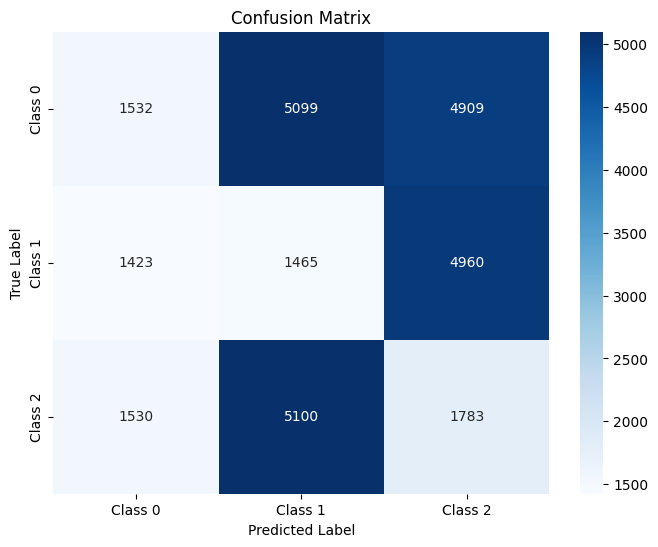

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the confusion matrix from a text file
file_path = '/content/orginalmatrix.txt'

# Read the file and convert it to a NumPy array
with open(file_path, 'r') as file:
    lines = file.readlines()
    # Strip any leading/trailing whitespace and split by spaces
    conf_matrix = np.array([list(map(int, line.split())) for line in lines])

# Check the shape of the matrix
print("Shape of the confusion matrix:", conf_matrix.shape)

# Ensure the matrix is 2D and square
if conf_matrix.ndim != 2:
    raise ValueError("The loaded confusion matrix must be 2D")
if conf_matrix.shape[0] != conf_matrix.shape[1]:
    raise ValueError("The confusion matrix must be square")

# Calculate total samples
total_samples = conf_matrix.sum()
print("Total samples:", total_samples)

# Generate true labels from the confusion matrix
true_labels = np.repeat(np.arange(conf_matrix.shape[0]), conf_matrix.sum(axis=1))

# Debugging output for true labels
print("True labels length:", len(true_labels))
print("True labels:", true_labels)

# Generate predicted labels from the confusion matrix
predicted_labels = []
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        predicted_labels.extend([j] * conf_matrix[i, j])
predicted_labels = np.array(predicted_labels)

# Debugging output for predicted labels
print("Predicted labels length:", len(predicted_labels))
print("Predicted labels:", predicted_labels)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

# Generate classification report
class_report = classification_report(true_labels, predicted_labels, target_names=['Class 0', 'Class 1', 'Class 2'])

# Print results
print("Confusion Matrix:")
print(conf_matrix)
print("\nAccuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:")
print(class_report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
